## Imports : 

In [1]:
from google.colab import drive
import os 
import tempfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time
import pickle

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Constants : 
styles = os.listdir('/content/drive/MyDrive/DL/Project/my_data')
n_classes = (len(styles))
print(styles)
print(n_classes)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']
25


In [4]:
# Constants : 
size = 224
imgSize = (size, size)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar(shrink=0.75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation='vertical')
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('Actual label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [6]:
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

## Loading the data for Inception :

In [7]:
PIK = "/content/drive/MyDrive/DL/Project/x_inception.dat"
PIK1 = "/content/drive/MyDrive/DL/Project/y_inception.dat"

In [8]:
x = []
with open(PIK, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK1, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [9]:
# Spliting the data : 
data_train, data_test, labels_train, labels_test = train_test_split(
x, y, train_size = 0.8, stratify = y, random_state=42)

In [10]:
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test, train_size = 0.5, stratify = labels_test, random_state=42)

In [7]:
PIK = "/content/drive/MyDrive/DL/Project/pickle_inception_train.dat"
PIK1 = "/content/drive/MyDrive/DL/Project/pickle1_inception_train.dat"
PIK2 = "/content/drive/MyDrive/DL/Project/pickle_inception_val.dat"
PIK3 = "/content/drive/MyDrive/DL/Project/pickle1_inception_val.dat"
PIK4 = "/content/drive/MyDrive/DL/Project/pickle_inception_test.dat"
PIK5 = "/content/drive/MyDrive/DL/Project/pickle1_inception_test.dat"

### Saving the different splits : 

In [12]:
with open(PIK, "wb") as f:
    pickle.dump(len(data_train), f)
    for value in data_train:
        pickle.dump(value, f)

In [13]:
with open(PIK1, "wb") as f:
    pickle.dump(len(labels_train), f)
    for value in labels_train:
        pickle.dump(value, f)

In [14]:
with open(PIK2, "wb") as f:
    pickle.dump(len(data_validation), f)
    for value in data_validation:
        pickle.dump(value, f)

In [15]:
with open(PIK3, "wb") as f:
    pickle.dump(len(labels_validation), f)
    for value in labels_validation:
        pickle.dump(value, f)

In [16]:
with open(PIK4, "wb") as f:
    pickle.dump(len(data_test), f)
    for value in data_test:
        pickle.dump(value, f)

In [17]:
with open(PIK5, "wb") as f:
    pickle.dump(len(labels_test), f)
    for value in labels_test:
        pickle.dump(value, f)

### Loading the train and validation split : 

In [8]:
x = []
with open(PIK, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK1, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [9]:
data_train=np.array(x)

In [10]:
y = np.array(y)

In [11]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [12]:
labels_train = y.astype(int)

In [13]:
labels_train = to_categorical(labels_train)

In [14]:
x = []
with open(PIK2, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK3, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [15]:
data_validation=np.array(x)

In [16]:
y = np.array(y)

In [17]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [18]:
labels_validation = y.astype(int)

In [19]:
labels_validation = to_categorical(labels_validation)

In [20]:
# Loading the pre-trained model
inception = InceptionV3(weights='imagenet', input_shape=(size,size,3), include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [21]:
# Regulizing the model
inception = add_regularization(inception)

In [22]:
# Freezing the layers : 
for layer in inception.layers:
    layer.trainable = False

In [23]:
# add a global spatial average pooling layer
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(124, activation='relu')(x)
# and a logistic layer
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inception.input, outputs=predictions)


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
model.compile(
  loss='categorical_crossentropy',
  optimizer = "adam",
  metrics=['accuracy']
)

In [26]:
tf.config.run_functions_eagerly(True)

In [27]:
r = model.fit(data_train, labels_train,  epochs=30, validation_data=(data_validation, labels_validation),  callbacks = [TensorBoard(log_dir="./logs")])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
252/252 [==============================] - 108s 376ms/step - loss: 4.2528 - accuracy: 0.1315 - val_loss: 3.1716 - val_accuracy: 0.3562
Epoch 2/30
252/252 [==============================] - 85s 337ms/step - loss: 3.2767 - accuracy: 0.3375 - val_loss: 2.8907 - val_accuracy: 0.4425
Epoch 3/30
252/252 [==============================] - 94s 373ms/step - loss: 3.0572 - accuracy: 0.3914 - val_loss: 2.7624 - val_accuracy: 0.5030
Epoch 4/30
252/252 [==============================] - 89s 355ms/step - loss: 2.9479 - accuracy: 0.4390 - val_loss: 2.7345 - val_accuracy: 0.5248
Epoch 5/30
252/252 [==============================] - 86s 343ms/step - loss: 2.8394 - accuracy: 0.4676 - val_loss: 2.6510 - val_accuracy: 0.5427
Epoch 6/30
252/252 [==============================] - 97s 386ms/step - loss: 2.7652 - accuracy: 0.4871 - val_loss: 2.6279 - val_accuracy: 0.5605
Epoch 7/30
252/252 [==============================] - 85s 339ms/step - loss: 2.7206 - accuracy: 0.5010 - val_loss: 2.6167 - val_a

### Thiss time our model performs worse than ResNet. 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [28]:
loss = r.history['loss']
val_loss = r.history['val_loss']

In [29]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

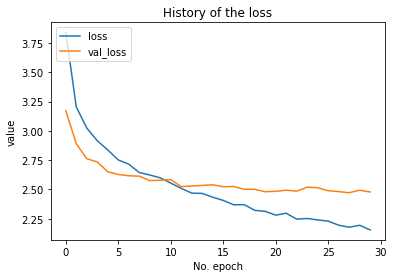

In [30]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('History of the loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig('/content/drive/MyDrive/DL/Project/inception_loss.png')
plt.show()

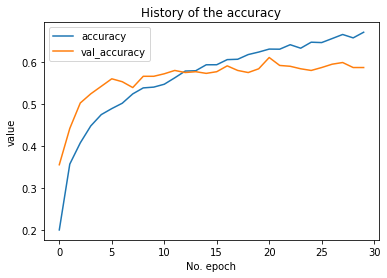

In [31]:
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title('History of the accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig('/content/drive/MyDrive/DL/Project/inception_acc.png')
plt.show()

### On first sight the graphs looks even better, especially the generalization of the model. However, it is important to pay attention to their values, which clearly show us that Inception is worse. 

However, we are going to save it and see the cases which are predicted appropriately.

In [32]:
model.save('/content/drive/MyDrive/DL/Project/inception.hdf5')

In [44]:
model = load_model('/content/drive/MyDrive/DL/Project/inception.hdf5')

In [34]:
x = []
with open(PIK4, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK5, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [35]:
data_test=np.array(x)

In [36]:
y = np.array(y)

In [37]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [38]:
labels_test = y.astype(int)

In [39]:
labels_test = to_categorical(labels_test)

In [45]:
Y_pred = model.predict(data_test)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [46]:
y_test = np.argmax(labels_test, axis=1)

In [47]:
y_pred

array([22, 13,  1, ...,  1, 15, 12])

In [48]:
print('Classification Report')
target_names = styles
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
                                  precision    recall  f1-score   support

         Achaemenid architecture       0.75      0.65      0.70        46
American Foursquare architecture       0.51      0.71      0.59        45
        American craftsman style       0.45      0.31      0.37        32
   Ancient Egyptian architecture       0.68      0.74      0.71        54
           Art Deco architecture       0.50      0.15      0.23        20
        Art Nouveau architecture       0.42      0.42      0.42        12
            Baroque architecture       0.48      0.68      0.56        50
            Bauhaus architecture       0.62      0.72      0.67        32
         Beaux-Arts architecture       0.25      0.24      0.24        42
          Byzantine architecture       0.73      0.41      0.52        27
     Chicago school architecture       0.69      0.41      0.51        27
           Colonial architecture       0.38      0.27      0.32        66
               

The scores are varying again. 

Confusion matrix, without normalization


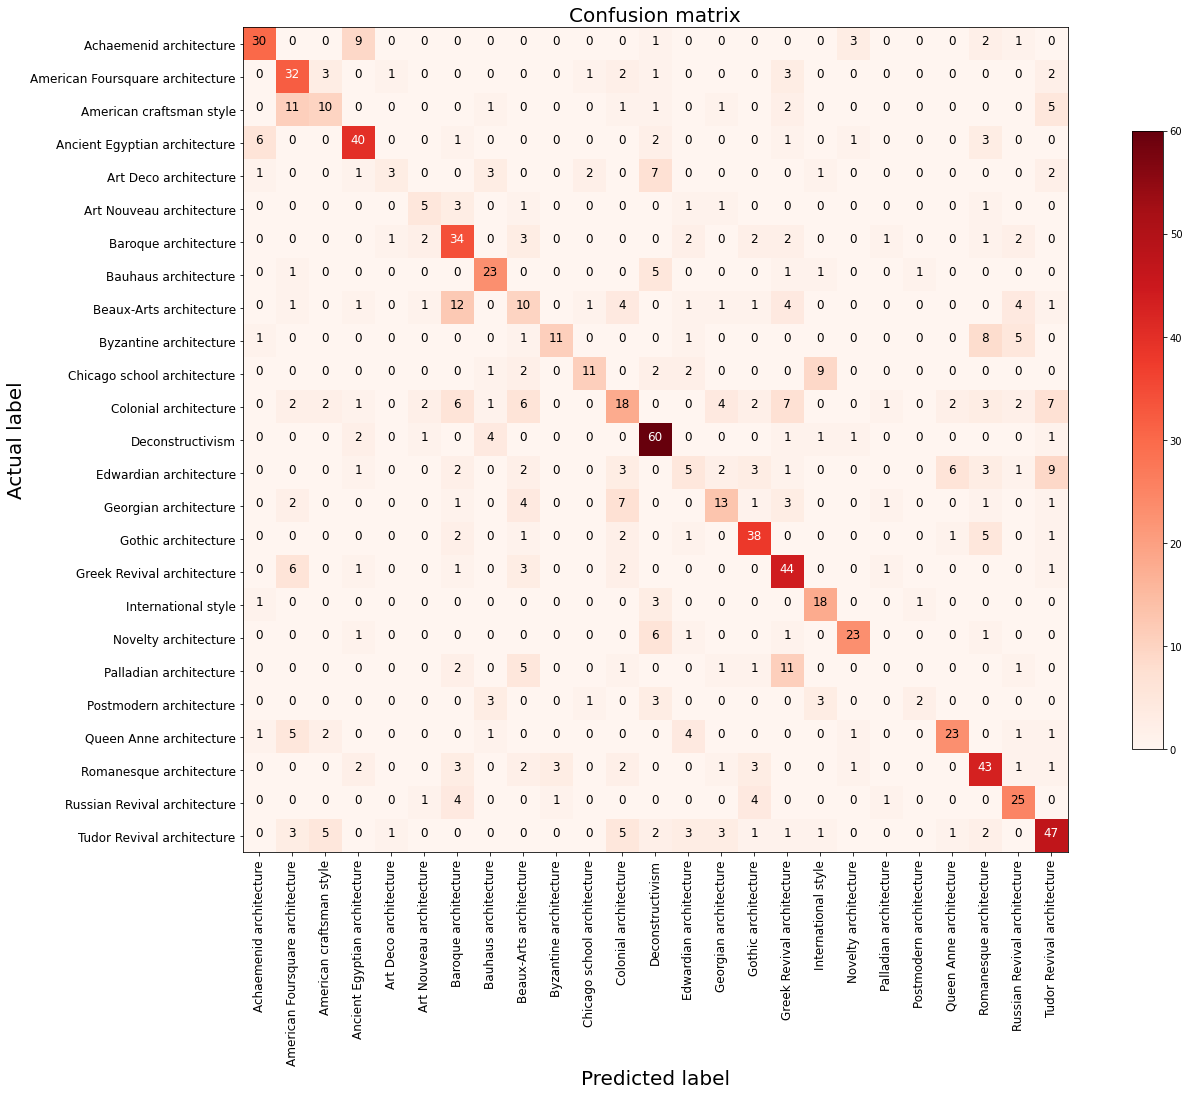

In [49]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(20, 15))
plot_confusion_matrix(cm, classes=styles)
plt.show()

### The confusion matrix is worse than the one by ResNet. There are place where the diagonal trend is even interupted. For that reason, we are going to proceed with ResNet model for the building of the app. The files for the app could be found in the directory of the project. Now I will attach my self-assesment. 

# Deep Learning
## Final Exam Assessment Guidelines

## Project name: Architectural Style Classifier 
## Project author: Dimitar Indzhov

### Terms and conditions:
* Use Jupyter notebook for text and maths. You can use any programming language you would like.
* Write your research and code in English. Bulgarian is also acceptable but try to use English.
* If you have sensitive, copyrighted, or copy-protected assets, including but not limited to, images, multimedia, code, documents, and datasets,
  you can sign an NDA (non-disclosure agreement) with the SoftUni team. Contact the lecturer if you need assistance with the process.
* Any code which does not comply with the Bulgarian law (as of the exam date), will be given zero points.
* Any malicious code, or code intended to do harm to the user's computer, information, or privacy, will be given zero points.

By submitting your project for the exam, you agree with these terms and conditions.

### Self-assessment:
The numbers in brackets define possible points for the corresponding item.
Replace the numbers in brackets with your own estimation.
** Example: **
1. Problem statement: 7
2. Problem description: 3
(end of example)

1. Problem statement (10)
	* How well is the problem defined?
    The problem is well defined with a research in the particular field - Architecture. 
	* Does the research address a real-life problem?
    The ability to define the architectural styles of a building could take you years of academic education. The inability of the machines doing it for our self is evident in the algorithms of Google and Bing. Those search engines were used in a big part of this project, as well. However, the gathered data had to be cleaned manually with background knowledge, which show us the problem is present, and the algorithms used now have to be improved. 
	* Does the research solve the correct problem?
    Yes. The problem is specific to the styles of he buildings, not the buildings, as a whole. The paper and blogs used in the research are again dedicated to this specific problem. 
2. Layout (18)
	* Are the document sections structured properly?
    Yes. However, the limit of Google Colab did not allow me to run the whole project on one single notebook. Even when the project was separated some of the sections had to be stoped on the middle, whiere the notebook was restarted and then started from that point. This was the only possible way for building this project. However, everything is documented. 
	* Is the article well-formatted (in terms of readability)?
    Yes, in the first notebooks there is a lot of information, apart from it the project have official page where everything is explained even more clearly. (all resources and links could be found in the first notebook and on the page.)
3. Code quality (18)
	* Is the code well-written? Is the code self-documenting?
    Yes, it is documented even the exact parts where some of the notebooks were restarted. 
	* Is the code organized into functions?
    Yes, in the begining of almost any notebook there are functions with constants. 
	* Is the code generally well-structured?
    Yes, it is logically structured, and with more powerful machine everything could be run in a single notebook. 
4. Previous research (10)
	* Have you cited at least two other sources?
    Yes, they are even three. 
	* Does the project contain comparisons between the current and the previous results?
    Yes, it is pointed twice that this project sums the data from two previous sources, as well as third one (which is mine personal). Also, it is again noted that the previous project were trained on wrong data, which was recognized and cleaned from me manualy with background knowledge. Thus, as I stated in the official page : I am confident to claim that there is no better data set for such task on the network right now. 
5. Gathering / generating, cleaning, and formatting data (10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data.
    I downloaded 2/3 of my data, gathered 1/3 on my own. Finally, cleaned the culumative data. All of it is formed from real life photos. 
	* How is the data gathered?
    From bing search .
	* Is the process statistically valid?
    Yes, it not only show results in the visualizing, but in the training with the different models. Which shows that the data for the different models was proceeded with their own "preprocess_input" functions. 
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
    Yes, however, the "real" cleaning is not precisely documented, as I have to do it manualy. The time for the project was not enough to write the name of every single image and my arguments for deleting it.
6. Testing (8)
	* This can have various meanings: unit testing, hypothesis testing, train/test data set, etc.
    Yes, I rised a hypothesis from the first notebook. However, it was not possible to be documented with evidence, for that reason I give my self lower points .
	* Is the code thoroughly tested?
    Yes, there are places where I checked the number of the splits, the time of execution, the variance ration, or the readibility of the images in the processing. 
	* Are there any comparisons to other implementations / other articles / previous research?
    Yes, there is even a footnotes of codes which I used. 
7. Visualization (8)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
    Yes, they show that the data is corectly procceded or the real life problem of not having equal examples for each architecture, which is easily understood.  
	* Are all visualizations clear, and easy to understand?
    Yes, however, some of the tSNE visualizations are not quite clear. The reason is the varity of the data. 
8. Communication (10)
	* Does the project tell the story correctly?
    Yes 
	* Does the project serve the audience it was intended for?
    Yes, as the main idea of the project is to give the lay and not very educated traveler to be engaged with the cultural information around him/her while visiting new city. For that reason, was created the app - easily usage, without going so deep in the whole project. 